### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jul 29 11:44:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 89.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s et

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-07-29 11:46:09--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.004s  

2025-07-29 11:46:09 (27.9 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [7]:
# import cv2
# from ultralytics import YOLO
# import supervision as sv


# image_path = f"{HOME}/xcBYLI.png"
# image = cv2.imread(image_path)

# model = YOLO('yolov12l.pt')

# results = model(image, verbose=False)[0]
# detections = sv.Detections.from_ultralytics(results)

# box_annotator = sv.BoxAnnotator()
# label_annotator = sv.LabelAnnotator()

# annotated_image = image.copy()
# annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
# annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weeds-3 in yolov11:: 100%|██████████| 8418/8418 [00:01<00:00, 6618.77it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Weeds']

roboflow:
  workspace: augmented-startups
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/kaggle/working/Weeds-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]
E0000 00:00:1753789848.565881      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753789848.662262      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 73.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Weeds-3/train/labels... 3664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3664/3664 [00:02<00:00, 1469.05it/s]


train: New cache created: /kaggle/working/Weeds-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /kaggle/working/Weeds-3/valid/labels... 359 images, 0 backgrounds, 0 corrupt: 100%|██████████| 359/359 [00:00<00:00, 1349.79it/s]

val: New cache created: /kaggle/working/Weeds-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.75G       2.98      3.382      3.715         99        640: 100%|██████████| 229/229 [02:04<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


                   all        359        920     0.0277      0.205     0.0189    0.00624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.85G      2.086      2.166      2.486         89        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

                   all        359        920      0.495      0.502      0.482      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.66G      1.962      2.001      2.316         87        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.692      0.465      0.575      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       6.7G      1.862      1.855      2.188         66        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

                   all        359        920      0.571       0.58      0.609      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.84G      1.798      1.786       2.12         67        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.639      0.591      0.643      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.65G      1.734      1.701      2.055         61        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

                   all        359        920      0.628      0.647      0.683      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.87G      1.638       1.59      1.969         68        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.735       0.55      0.678      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.87G       1.62      1.551      1.936         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.709       0.68      0.747      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.67G      1.576       1.49        1.9         59        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.714      0.664      0.708      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.81G      1.565      1.462      1.889        103        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.832      0.655       0.79      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.85G      1.536      1.423       1.85         81        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920       0.81       0.67      0.783      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.84G      1.513      1.384      1.817         43        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.839      0.687      0.802      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.72G      1.493      1.342      1.799        105        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.823      0.729      0.837      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.7G      1.455      1.297      1.774         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.858      0.729      0.851      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.68G      1.453      1.283       1.76         56        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.847      0.743      0.841      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.68G      1.427      1.254      1.727         78        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.855      0.738      0.854      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.85G      1.414       1.22      1.711         73        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.878      0.774      0.878      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.84G      1.408       1.21      1.714         74        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920       0.86      0.788      0.872      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.84G        1.4      1.185      1.701         57        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]

                   all        359        920      0.844      0.752      0.846      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.84G      1.396      1.184      1.697         92        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920       0.83      0.836       0.89       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.66G      1.366      1.151      1.675         76        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.865      0.796      0.884      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       6.7G      1.355      1.127      1.659         86        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.859      0.775      0.883       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.68G      1.354      1.108      1.654        114        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920       0.88      0.798      0.892      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.7G       1.34      1.087      1.642         97        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.855      0.836      0.895      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.83G      1.336      1.092      1.626         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.883      0.805      0.906      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.89G       1.32      1.061      1.616         74        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.862      0.846      0.907      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.84G      1.308      1.044      1.604         92        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.845      0.843      0.912       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.82G      1.307       1.06      1.611         66        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.888      0.839      0.919      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.69G      1.288      1.025      1.587         68        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.858      0.807      0.897      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.67G      1.282      1.023      1.577        111        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.898       0.84      0.919      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.68G      1.281      1.006      1.581         92        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.895      0.863      0.933      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       6.7G      1.272     0.9837      1.569         90        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.855      0.852      0.914      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.82G      1.267     0.9802      1.557         55        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920       0.88      0.867      0.932      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.89G      1.259     0.9793      1.553         62        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.875      0.852      0.932       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.86G      1.242     0.9553      1.544         61        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.894      0.851      0.929      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.86G      1.238     0.9601      1.531         93        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.897      0.857      0.933      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.66G      1.231     0.9373      1.531         52        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.902      0.867      0.938      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.68G      1.221     0.9218      1.516         64        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.879      0.876      0.937      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.68G      1.226     0.9294      1.526         98        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.892      0.866      0.935      0.666



     43/100      6.67G      1.211     0.9123       1.51         58        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.893      0.874       0.94      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.83G       1.21     0.9156      1.517         78        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.854      0.892      0.941      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.84G      1.189     0.8789      1.487         65        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.906      0.864      0.939      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.82G      1.194     0.8963      1.502         89        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.909      0.893      0.946      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.69G      1.186      0.878      1.474        102        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.901      0.895      0.948      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.65G      1.176     0.8693      1.475         51        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.907      0.885      0.948      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.72G      1.176     0.8672       1.47         63        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920       0.89      0.902      0.945      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.84G       1.16     0.8419      1.451         86        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920        0.9      0.889      0.951      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       6.7G      1.146     0.8316      1.452         76        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.888      0.912      0.956      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.84G      1.136     0.8256      1.439         80        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.903      0.924      0.958      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.87G      1.144     0.8177      1.444         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.928      0.896      0.957      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.69G      1.142     0.8306      1.446         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.893      0.906      0.947      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.68G      1.122     0.8069      1.429         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.887       0.91      0.953      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.67G       1.12      0.795      1.426         87        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.913      0.903      0.955      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.67G      1.112     0.7972      1.416         67        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.912      0.907      0.956      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.87G      1.107     0.7824      1.408         74        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920        0.9      0.929      0.957      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.86G       1.09     0.7751      1.399         50        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920       0.92      0.922      0.962      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.86G      1.088     0.7785      1.397         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.918      0.915      0.962      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.66G      1.078     0.7597      1.388         65        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

                   all        359        920      0.912      0.919      0.961      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.83G      1.065     0.7571      1.386         78        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.902      0.929      0.962      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.83G      1.063     0.7601      1.381         45        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.892      0.936       0.96      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.83G      1.053     0.7317      1.363         66        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.911       0.93      0.964      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.84G      1.047     0.7407      1.366         65        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.906      0.933      0.963      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.84G      1.034      0.735      1.358         52        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.919      0.922      0.962      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.84G      1.037     0.7317      1.354         64        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.923      0.927      0.966      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.71G       1.02     0.7191      1.349         67        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.926      0.923      0.967      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.7G      1.021     0.7202      1.341         62        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920       0.93      0.932      0.967      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.7G      1.022     0.7196       1.34         82        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.931      0.928      0.967      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.7G      1.011     0.7111      1.335         68        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.922      0.923      0.965      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.83G      1.001     0.7029      1.328         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.914      0.942      0.968      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.67G     0.9952     0.6951      1.325         52        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.919      0.937      0.968      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.87G     0.9887     0.6953      1.321         67        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.911      0.933      0.965      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.84G     0.9966     0.7001      1.327         60        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.932      0.933      0.967      0.739



     80/100      6.67G     0.9811     0.6816      1.307         93        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.931      0.926      0.969      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.68G     0.9879     0.6805      1.311         80        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.925      0.935      0.969      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.68G     0.9826     0.6792      1.313         86        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.922      0.939       0.97      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.7G     0.9748      0.679      1.307         81        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.918      0.934      0.969      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.83G      0.967     0.6713      1.301         59        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920       0.93      0.933      0.969      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.87G     0.9686     0.6783      1.307         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.936      0.934       0.97      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.84G     0.9574     0.6656      1.294         47        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.927      0.938      0.971      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.67G     0.9507     0.6554      1.281         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.935      0.931       0.97      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.65G     0.9562     0.6613      1.291         72        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920       0.93      0.935      0.971      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.82G     0.9403     0.6529      1.281         68        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.939       0.93       0.97      0.752


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       6.7G     0.8855     0.5257       1.24         33        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.936      0.933       0.97      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.81G      0.855     0.4958       1.22         54        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.945      0.933      0.974      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.84G      0.845     0.4874      1.213         35        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.938      0.936      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.84G     0.8476      0.493      1.213         40        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.931      0.938      0.972      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.84G     0.8305      0.474        1.2         22        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.944      0.931      0.972      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.65G     0.8295     0.4747      1.198         33        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.937      0.938      0.972      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.65G     0.8203     0.4696      1.194         40        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.933       0.94      0.971      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.82G     0.8234     0.4781      1.196         39        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.937      0.942      0.972      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.81G     0.8178     0.4662      1.189         25        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.939      0.937      0.972      0.771



100 epochs completed in 3.489 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


                   all        359        920       0.94      0.937      0.972      0.772


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 9.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					  train_batch1.jpg
confusion_matrix_normalized.png			  train_batch20610.jpg
confusion_matrix.png				  train_batch20611.jpg
events.out.tfevents.1753789862.a5a8abab1227.77.0  train_batch20612.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


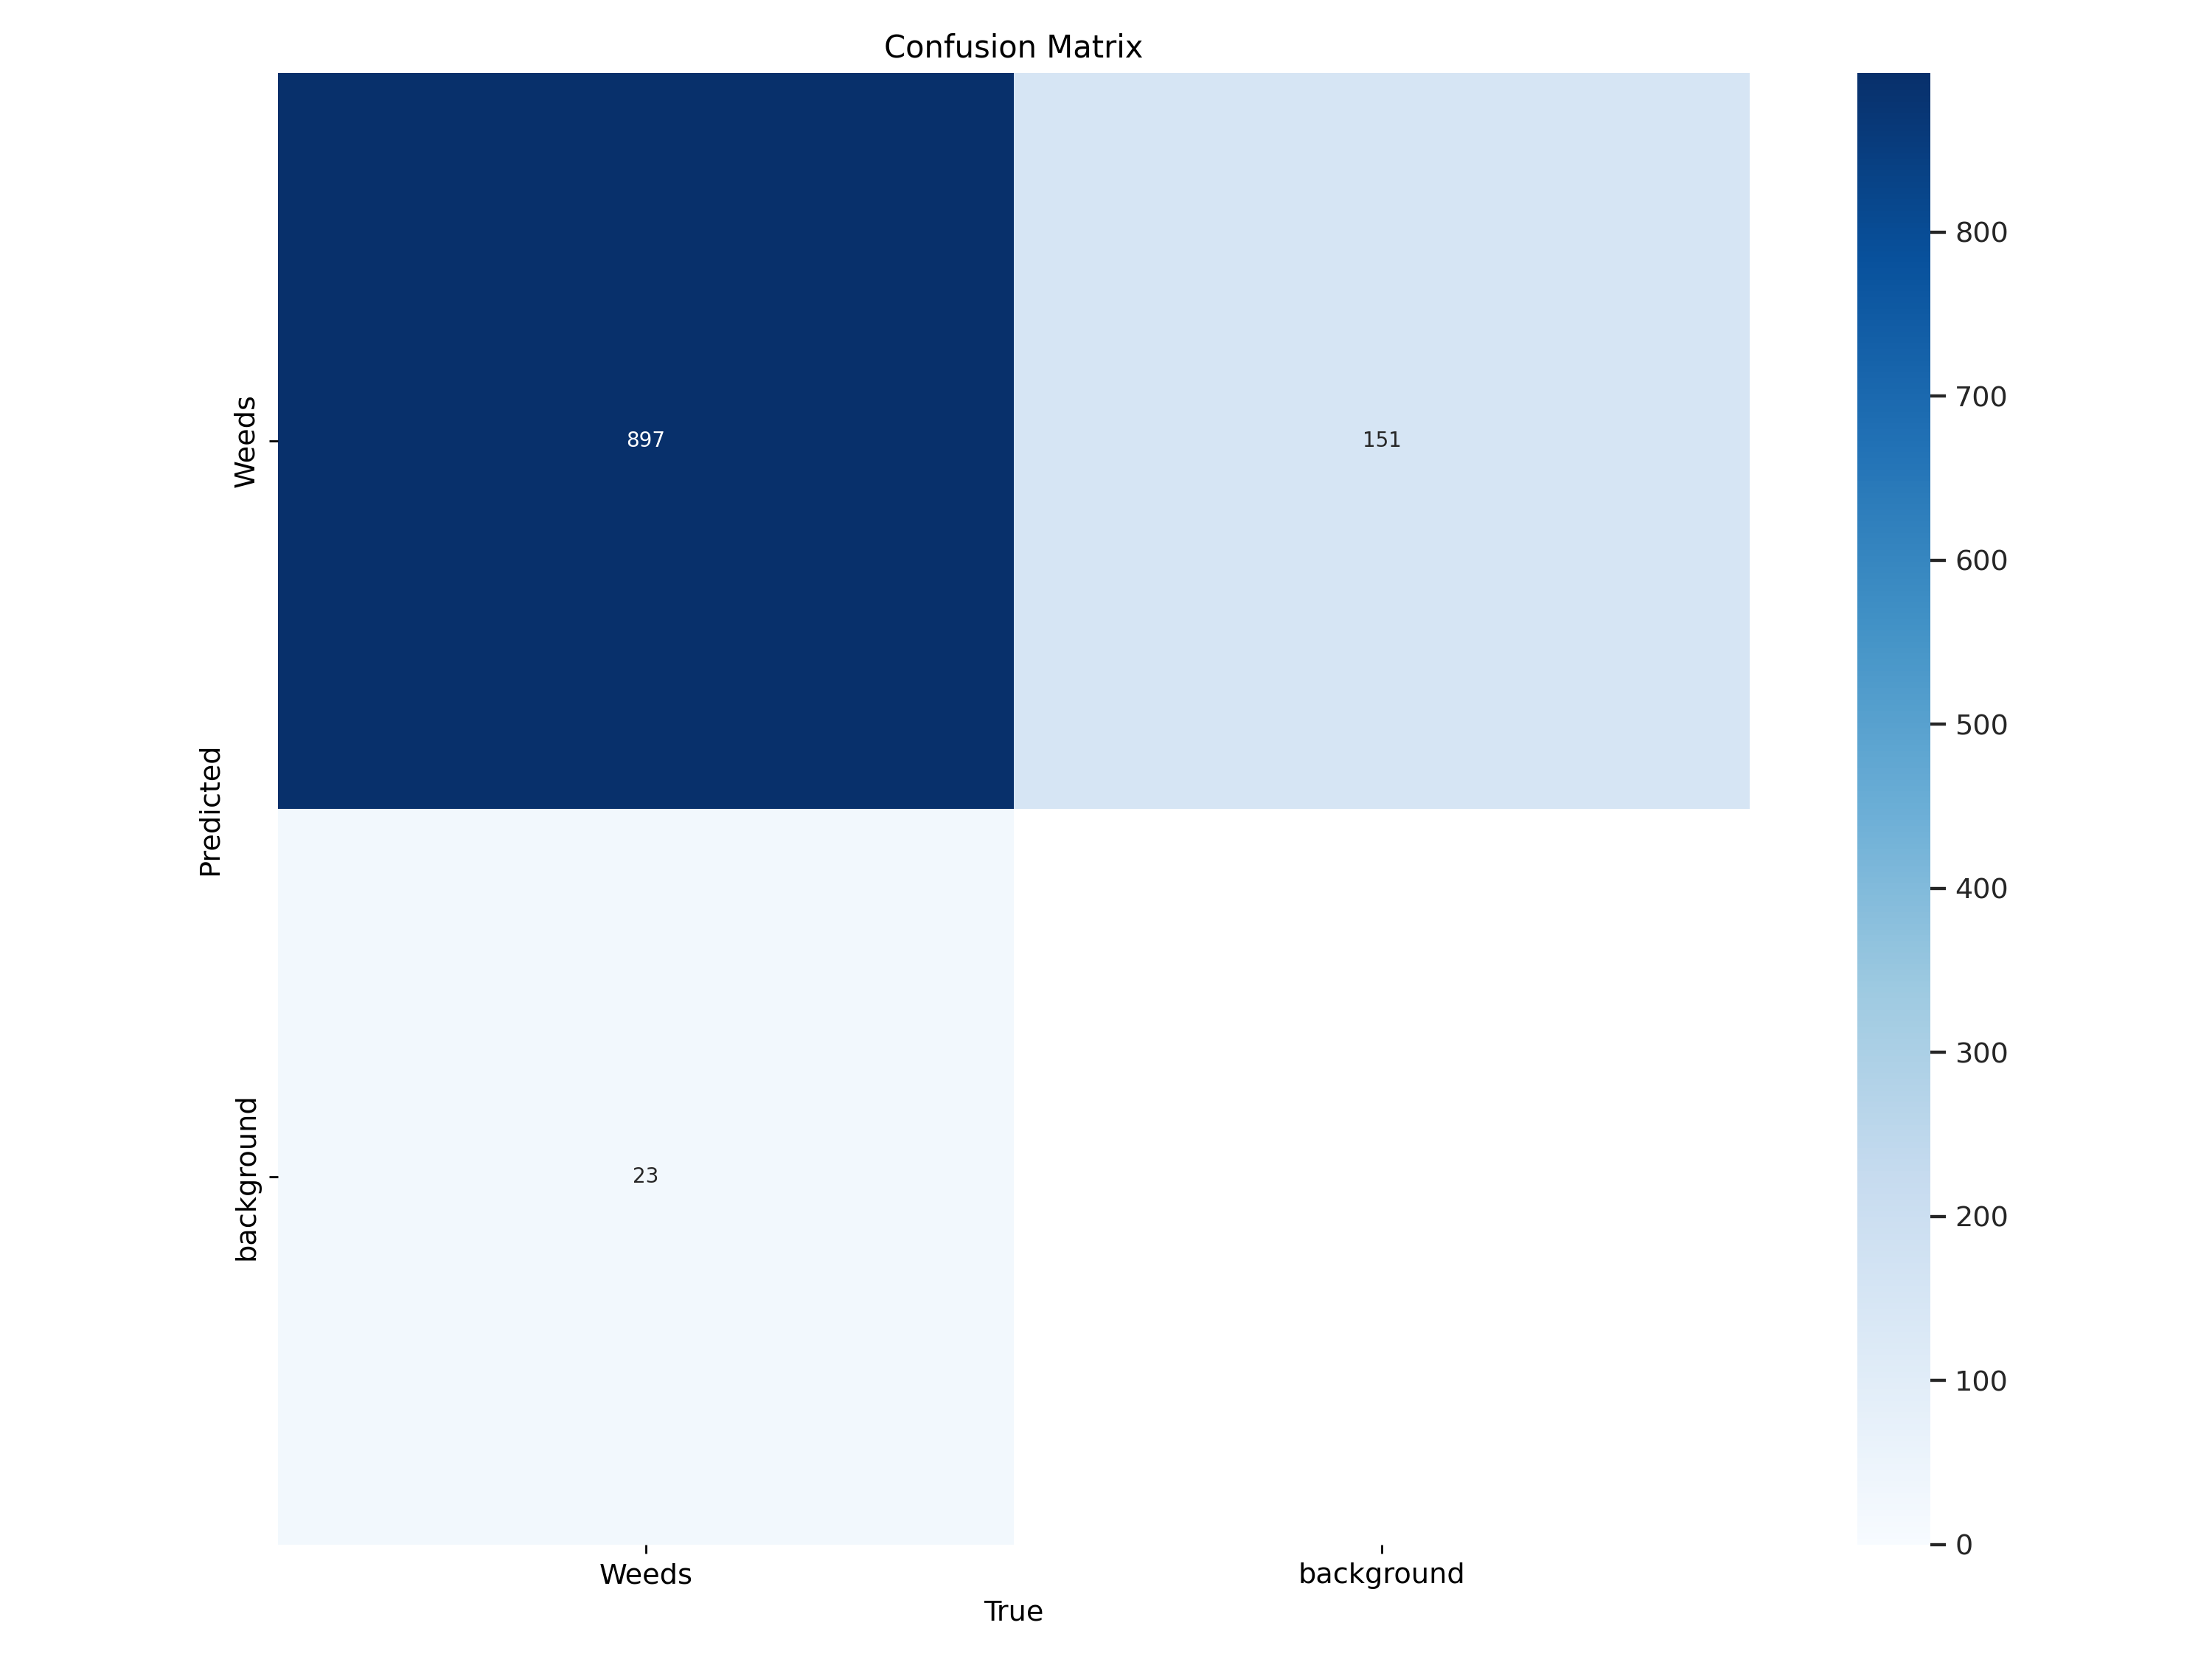

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

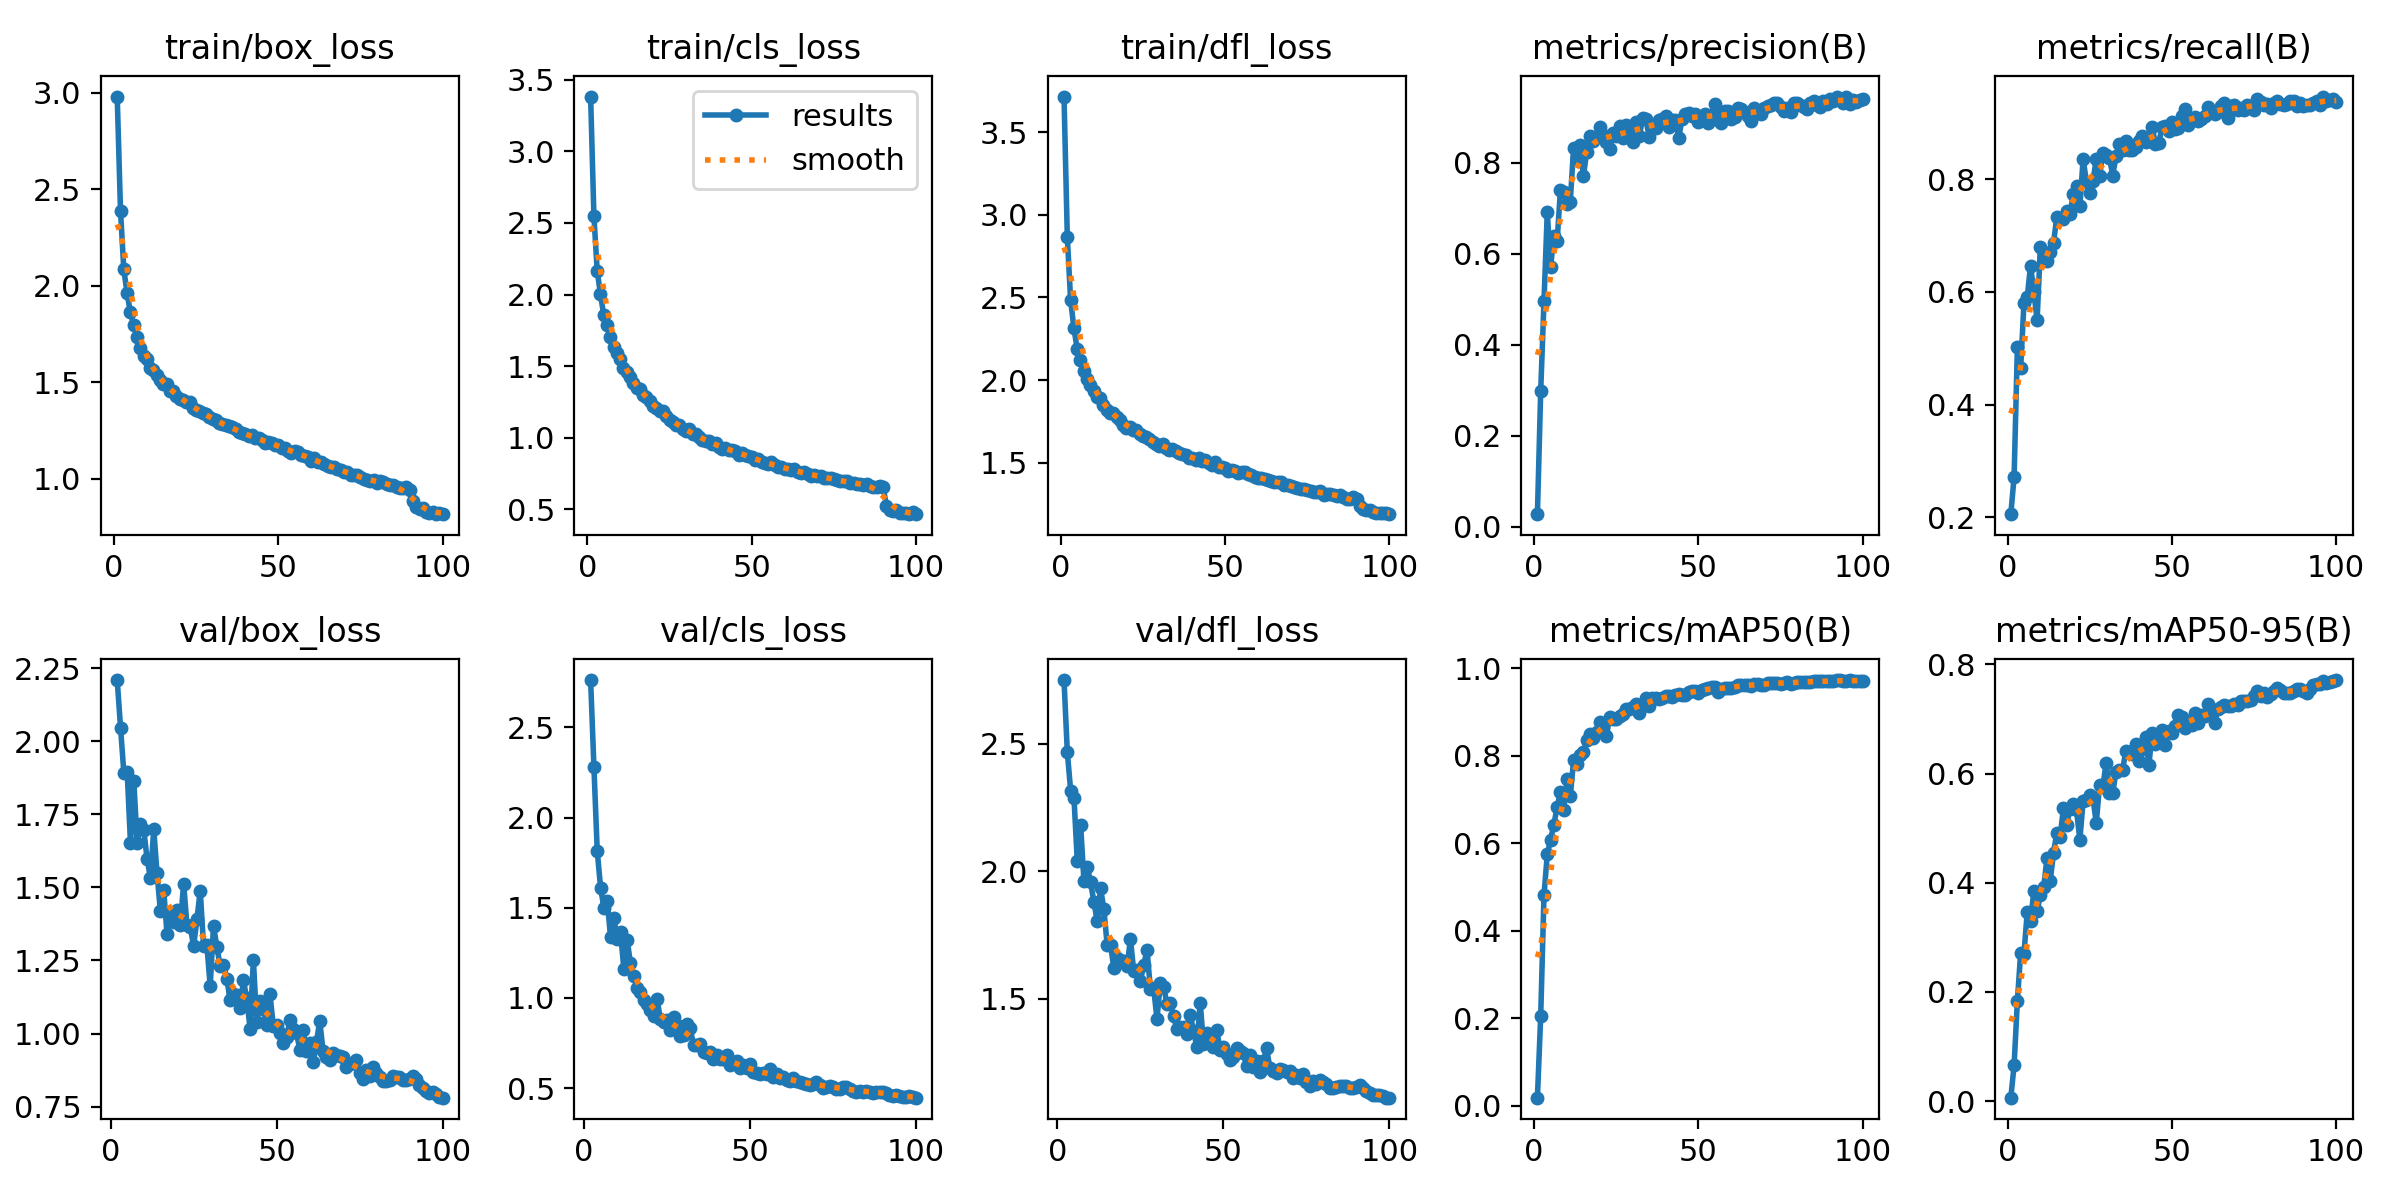

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Weeds']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6734677319110481
mAP 50 0.9736471733339972
mAP 75 0.829370211610186


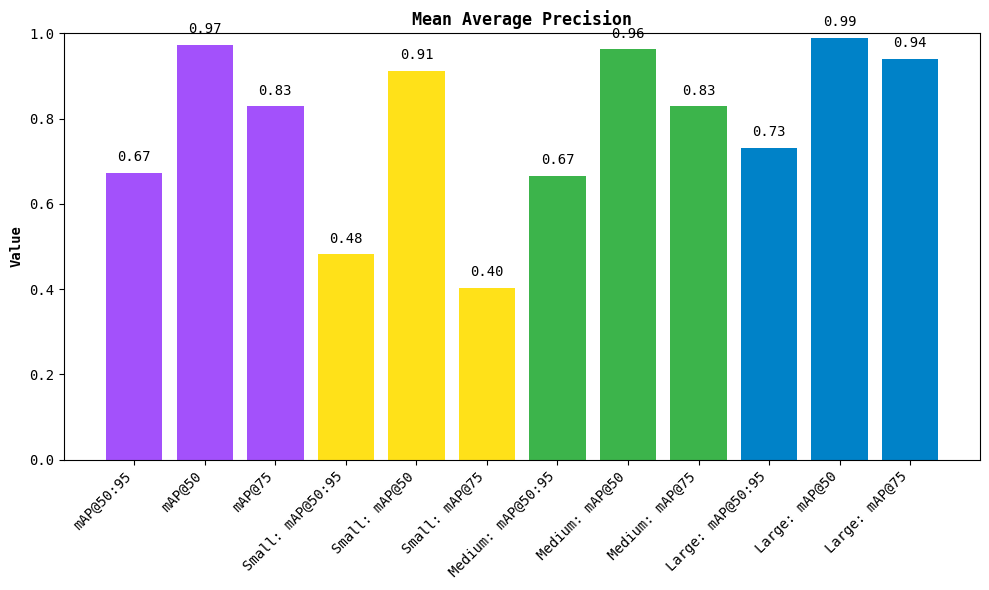

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

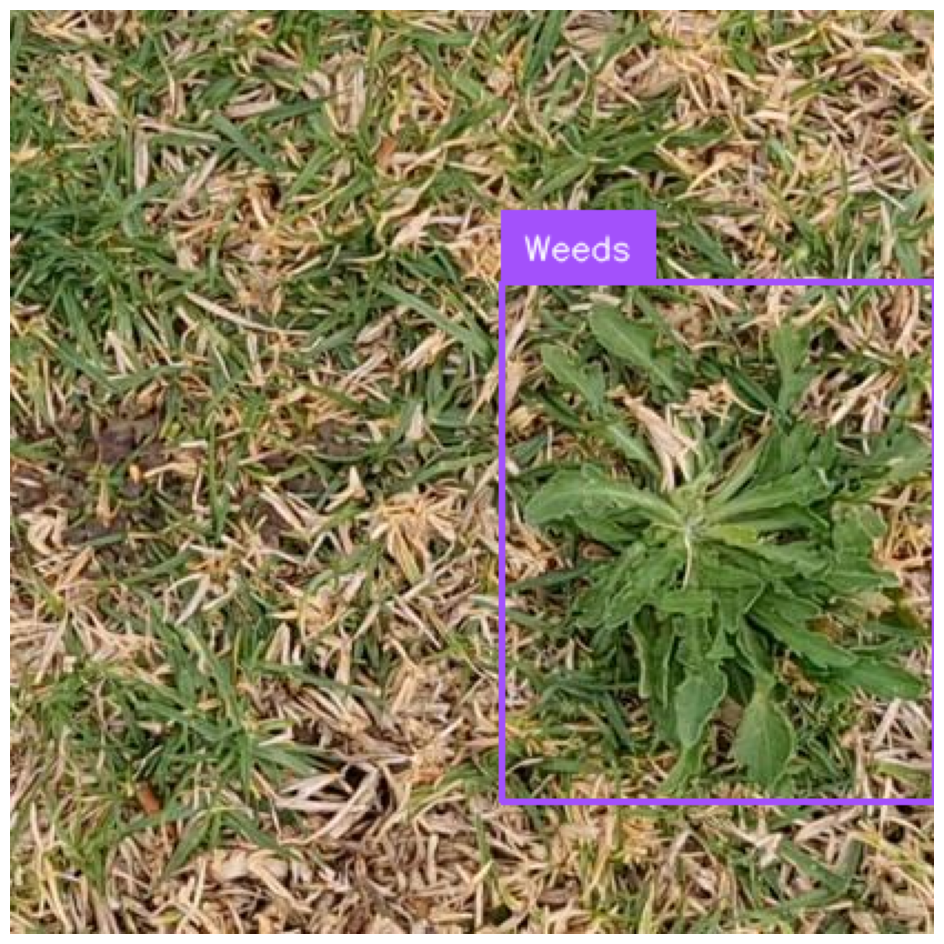

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)